## Trait-management performance
Quantifying performance of different trait combinations in terms of __yield__ & __yield variance__

In [19]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from palettable.colorbrewer.sequential import YlGn_9
from palettable.cmocean.sequential import Tempo_10
from palettable.cartocolors.qualitative import Vivid_5
from palettable.colorbrewer.qualitative import Set2_5

from ideotype.data_process import read_sims, read_data, parse_mature
from ideotype.utils import custom_colormap

In [2]:
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_present.yml')
df_extended, df_stuck = parse_mature(df_all)

### High performing trait-management combination for each site

Text(0.5, 1.0, 'varaince across years averaged over all sites')

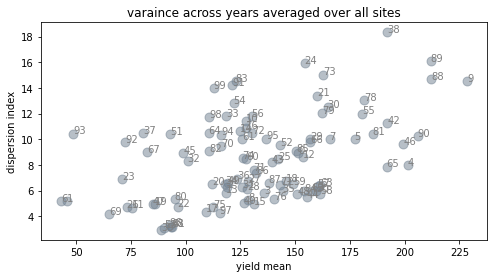

In [3]:
# yield variance across site & years
yield_mean = df_all.groupby('cvar').mean().dm_ear
yield_variance = df_all.groupby('cvar').var().dm_ear

# visulization
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
sc = ax.scatter(yield_mean, yield_variance/yield_mean, c='slategrey', s=80, alpha=0.5)
for i in np.arange(100):
    ax.annotate(i, (yield_mean[i], yield_variance[i]/yield_mean[i]), c='grey')
    
ax.set_xlabel('yield mean')
ax.set_ylabel('dispersion index')
ax.set_title('varaince across years averaged over all sites')
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/varstd_acrossyears.png', format='png', dpi=800)

### Top performing trait-management combination

In [4]:
# Set up sites
sites = list(set(df_all.site))
phenos = list(set(df_all.cvar))

# Parameters
n_yield = 20
n_pheno = 5
list_topphenos = [[] for item in np.arange(n_pheno)]

# Identify high performing combinations
for site in sites:
    df_sub = df_all.query(f'site=="{site}"')
    yield_mean = df_sub.groupby('cvar').mean().dm_ear
    yield_var = df_sub.groupby('cvar').var().dm_ear
    df_yield_mean = pd.DataFrame(yield_mean)
    df_yield_disp = pd.DataFrame(yield_var/yield_mean)
    
    select_highyield = list(df_yield_mean.nlargest(n_yield, columns='dm_ear').index.values)
    
    for item in np.arange(len(list_topphenos)):
        high_performance_pheno = list(
            df_yield_disp.iloc[select_highyield].nsmallest(n_pheno, columns='dm_ear').index.values)[item]
        list_topphenos[item].append(high_performance_pheno)

# Set up dataframe with top performing pheno info
df_pheno = pd.DataFrame(list_topphenos).transpose()
df_pheno.columns = [f'pheno{n+1}' for n in np.arange(n_pheno)]
df_pheno['sites'] = sites
df_pheno = pd.merge(df_pheno, df_sites, left_on='sites', right_on='site')

df_sites_sorted = pd.DataFrame(sorted(sites))
df_sites_sorted.columns = ['site']
df_sites_sorted['site_num'] = np.arange(len(sites))
df_pheno = pd.merge(df_pheno, df_sites_sorted, left_on='sites', right_on='site')

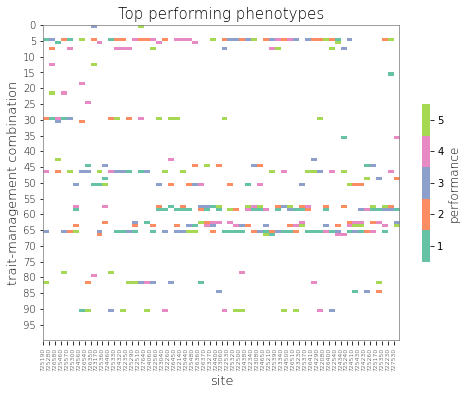

In [5]:
# Initiate empty matrix
mx = np.empty(shape=[len(phenos), len(sites)])
mx[:] = np.nan

# Fill in matrix data
for item in np.arange(n_pheno):
    mx[df_pheno[f'pheno{item+1}'], df_pheno['site_num']] = item + 1

# Visualization
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
cmap = sns.color_palette('Set2', n_pheno) 
hmap = sns.heatmap(mx, cmap=cmap, cbar_kws={'shrink': 0.5},)
hmap.axhline(y = 0, color='grey',linewidth=1.5)
hmap.axhline(y = mx.shape[0], color='grey', linewidth=1.5)
hmap.axvline(x = 0, color='grey', linewidth=1.5)
hmap.axvline(x = mx.shape[1], color='grey', linewidth=1.5)

colorbar = ax.collections[0].colorbar 
c_range = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + c_range / n_pheno * (0.5 + item) for item in range(n_pheno)])
colorbar.set_ticklabels(['1','2','3','4','5'])    

ax.set_title('Top performing phenotypes', fontweight='light', size=15)
ax.set_xlabel('site', fontweight='light', size=13)
ax.set_ylabel('trait-management combination', fontweight='light', size=13)
ax.figure.axes[-1].set_ylabel('performance', size=12, fontweight='light')

plt.xticks(np.arange(len(sites)))
plt.yticks(np.arange(0, len(phenos), 5))
ax.set_xticklabels(sites, fontsize=6, fontweight='light', rotation=90)
ax.set_yticklabels(np.arange(0, len(phenos), 5), fontsize=10, fontweight='light', rotation=0)

fig.subplots_adjust(bottom=0.15)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_topchoice.png', format='png', dpi=800)

### Define custom colormap
Should make into function

In [71]:
# Define custom colormap
cmap = plt.cm.tab20

# Extract all colors from colormap
cmaplist = [cmap(item) for item in range(cmap.N)]

# Create new map
num_colors = 25
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'custom_cmap', cmaplist, num_colors)

# Define bins and normalize
bounds = np.linspace(0, num_colors, num_colors+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

### Project onto map

In [87]:
# Fetch all high performing phenotype for all sites
phenos_all = []
for item in np.arange(n_pheno):
    phenos_all.extend(list(df_pheno.iloc[:,item]))
    
# Store into into dataframe
df_phenos_all = pd.DataFrame(phenos_all, columns=['pheno'])
df_phenos_all['count'] = 1
df_pheno_counts = df_phenos_all.groupby('pheno').sum()

# Loop through site
phenos_high_perform = []
for site in sorted(sites):
    df_pheno_site = df_pheno.query(f'sites=="{site}"')
    pheno_select = df_pheno_site.iloc[:, 0:n_pheno].values.tolist()[0]
    pheno_prevalent = df_pheno_counts.loc[pheno_select, 'count'].idxmax()
    phenos_high_perform.append(pheno_prevalent)

#### Highest performing pheno for all locations

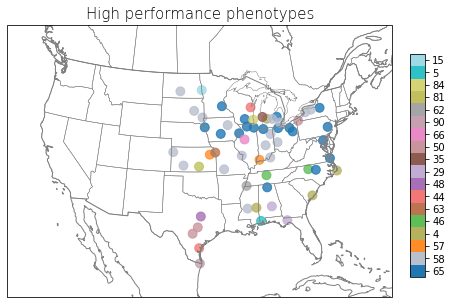

In [111]:
# Factorize pheno number
color_list = list(pd.factorize(df_pheno.pheno1)[0])

# Set up customized colormap
num_colors = len(set(color_list))
custom_cmap, bounds, norm = custom_colormap(num_colors)

# Visualization
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
mp = ax.scatter(df_pheno.lon, df_pheno.lat, transform=ccrs.PlateCarree(),
                c=color_list, cmap=custom_cmap, alpha=0.8, s=80)
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('High performance phenotypes', fontweight='light', size=15)

ax2 = fig.add_axes([0.93, 0.18, 0.03, 0.62])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=custom_cmap, norm=norm,
                               spacing='proportional', ticks=bounds, boundaries=bounds)

c_range = cb.vmax - cb.vmin 
cb.set_ticks([cb.vmin + c_range / num_colors * (0.5 + item) for item in range(num_colors)])
cb.set_ticklabels(list(pd.factorize(df_pheno.pheno1)[1]))

#### High performing pheno with highest pervelance at each location

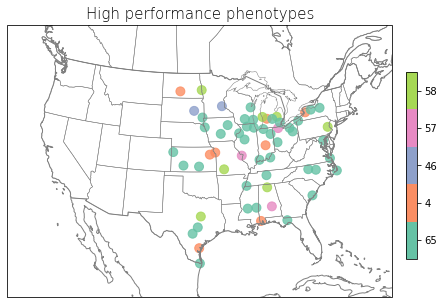

In [72]:
# Factorize pheno number
color_list = list(pd.factorize(phenos_high_perform)[0])

# Visualization
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
mp = ax.scatter(df_pheno.lon, df_pheno.lat, transform=ccrs.PlateCarree(),
                c=color_list, cmap=Set2_5.mpl_colormap, alpha=0.8, s=80)
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('High performance phenotypes', fontweight='light', size=15)

# Custom colorbar for qualitative data
ax2 = fig.add_axes([0.87, 0.23, 0.02, 0.52])
bounds = np.linspace(0, 5, 6)
norm = mpl.colors.BoundaryNorm(bounds, Set2_5.mpl_colormap.N)
cb = mpl.colorbar.ColorbarBase(ax2, cmap=Set2_5.mpl_colormap,
                               norm=norm, spacing='proportional', ticks=bounds+0.5, 
                               boundaries=bounds)
cb.set_ticklabels(list(pd.factorize(phenos_high_perform)[1]))

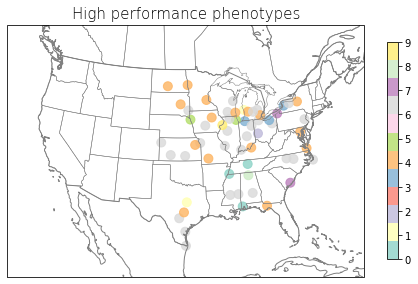

In [74]:
# Factorize pheno number
color_list = list(pd.factorize(phenos_high_perform)[0])

# Visualization
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))
ax.set_extent([-123, -72, 19, 53])
mp = ax.scatter(df_pheno.lon, df_pheno.lat, transform=ccrs.PlateCarree(),
                c=color_list, cmap='Set3', alpha=0.8, s=80)
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('High performance phenotypes', fontweight='light', size=15)
fig.colorbar(mp, shrink=0.8)

#ax2 = fig.add_axes([0.93, 0.18, 0.03, 0.62])
#cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
#    spacing='proportional', ticks=bounds, boundaries=bounds)

### High performing phenotypes in climate space
Should try some version of PCA on this data

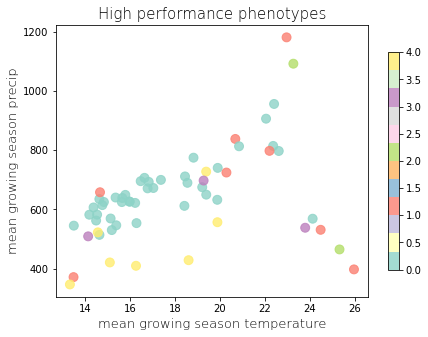

In [83]:
site_temps = df_all.groupby('site').mean().temp
site_vpds = df_all.groupby('site').mean().vpd
site_precips = df_all.groupby('site').mean().precip

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
sc = ax.scatter(site_temps, site_precips, c=color_list, cmap='Set3', s=80, alpha=0.8)
ax.set_title('High performance phenotypes', fontweight='light', size=15)
ax.set_xlabel('mean growing season temperature', fontweight='light', size=13)
ax.set_ylabel('mean growing season precip', fontweight='light', size=13)

fig.colorbar(sc, shrink=0.8)

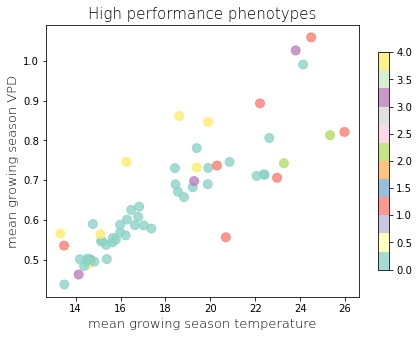

In [85]:
site_temps = df_all.groupby('site').mean().temp
site_vpds = df_all.groupby('site').mean().vpd
site_precips = df_all.groupby('site').mean().precip

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
sc = ax.scatter(site_temps, site_vpds, c=color_list, cmap='Set3', s=80, alpha=0.8)
ax.set_title('High performance phenotypes', fontweight='light', size=15)
ax.set_xlabel('mean growing season temperature', fontweight='light', size=13)
ax.set_ylabel('mean growing season VPD', fontweight='light', size=13)

fig.colorbar(sc, shrink=0.8)

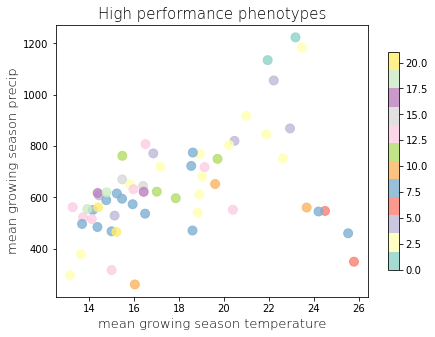

In [76]:
site_temps = df_all.groupby('site').mean().temp
site_vpds = df_all.groupby('site').mean().vpd
site_precips = df_all.groupby('site').mean().precip

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
sc = ax.scatter(site_temps, site_precips, c=color_list, cmap='Set3', s=80, alpha=0.8)
ax.set_title('High performance phenotypes', fontweight='light', size=15)
ax.set_xlabel('mean growing season temperature', fontweight='light', size=13)
ax.set_ylabel('mean growing season precip', fontweight='light', size=13)

fig.colorbar(sc, shrink=0.8)

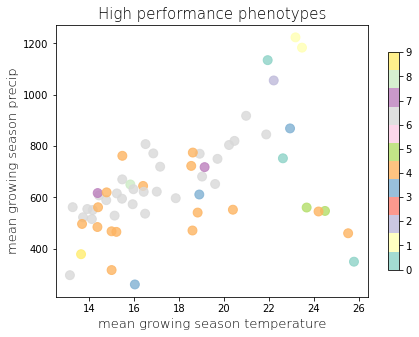

In [65]:
site_temps = df_all.groupby('site').mean().temp
site_vpds = df_all.groupby('site').mean().vpd
site_precips = df_all.groupby('site').mean().precip

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
sc = ax.scatter(site_temps, site_precips, c=color_list, cmap='Set3', s=80, alpha=0.8)
ax.set_title('High performance phenotypes', fontweight='light', size=15)
ax.set_xlabel('mean growing season temperature', fontweight='light', size=13)
ax.set_ylabel('mean growing season precip', fontweight='light', size=13)

fig.colorbar(sc, shrink=0.8)

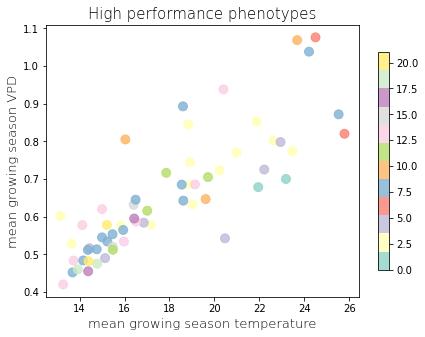

In [77]:
site_temps = df_all.groupby('site').mean().temp
site_vpds = df_all.groupby('site').mean().vpd
site_precips = df_all.groupby('site').mean().precip

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
sc = ax.scatter(site_temps, site_vpds, c=color_list, cmap='Set3', s=80, alpha=0.8)
ax.set_title('High performance phenotypes', fontweight='light', size=15)
ax.set_xlabel('mean growing season temperature', fontweight='light', size=13)
ax.set_ylabel('mean growing season VPD', fontweight='light', size=13)

fig.colorbar(sc, shrink=0.8)

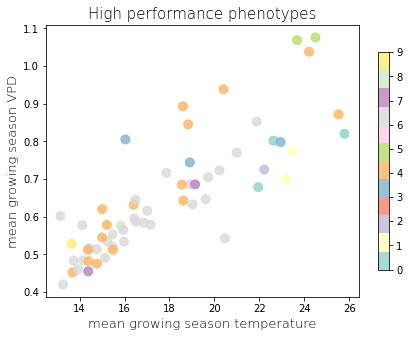

In [63]:
site_temps = df_all.groupby('site').mean().temp
site_vpds = df_all.groupby('site').mean().vpd
site_precips = df_all.groupby('site').mean().precip

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
sc = ax.scatter(site_temps, site_vpds, c=color_list, cmap='Set3', s=80, alpha=0.8)
ax.set_title('High performance phenotypes', fontweight='light', size=15)
ax.set_xlabel('mean growing season temperature', fontweight='light', size=13)
ax.set_ylabel('mean growing season VPD', fontweight='light', size=13)

fig.colorbar(sc, shrink=0.8)

### Compare ideotype yield vs. control yield